In [1]:

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn.mass_downloader import CircularDomain, \
    Restrictions, MassDownloader
from obspy.io.xseed import Parser
from obspy.signal import PPSD
from obspy.signal import freqattributes
import os
from scipy.fft import fft, ifft, fftfreq, next_fast_len
from scipy.integrate import cumtrapz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
#data_path = r"S:\Duynefontyn PSHA - DuynefontynPSHA\05 - GMM\GMM_Scripts\preprocessing"
#os.chdir(data_path)
#import the resposne spectrum script from working directory
#from response import *
from response_blz import *

AF.GRHM..HHZ | 2016-10-18T06:25:33.000000Z - 2016-10-18T06:30:33.000000Z | 100.0 Hz, 30001 samples
AF.GRHM..HHZ | 2016-10-18T06:25:33.000000Z - 2016-10-18T06:30:33.000000Z | 100.0 Hz, 30001 samples


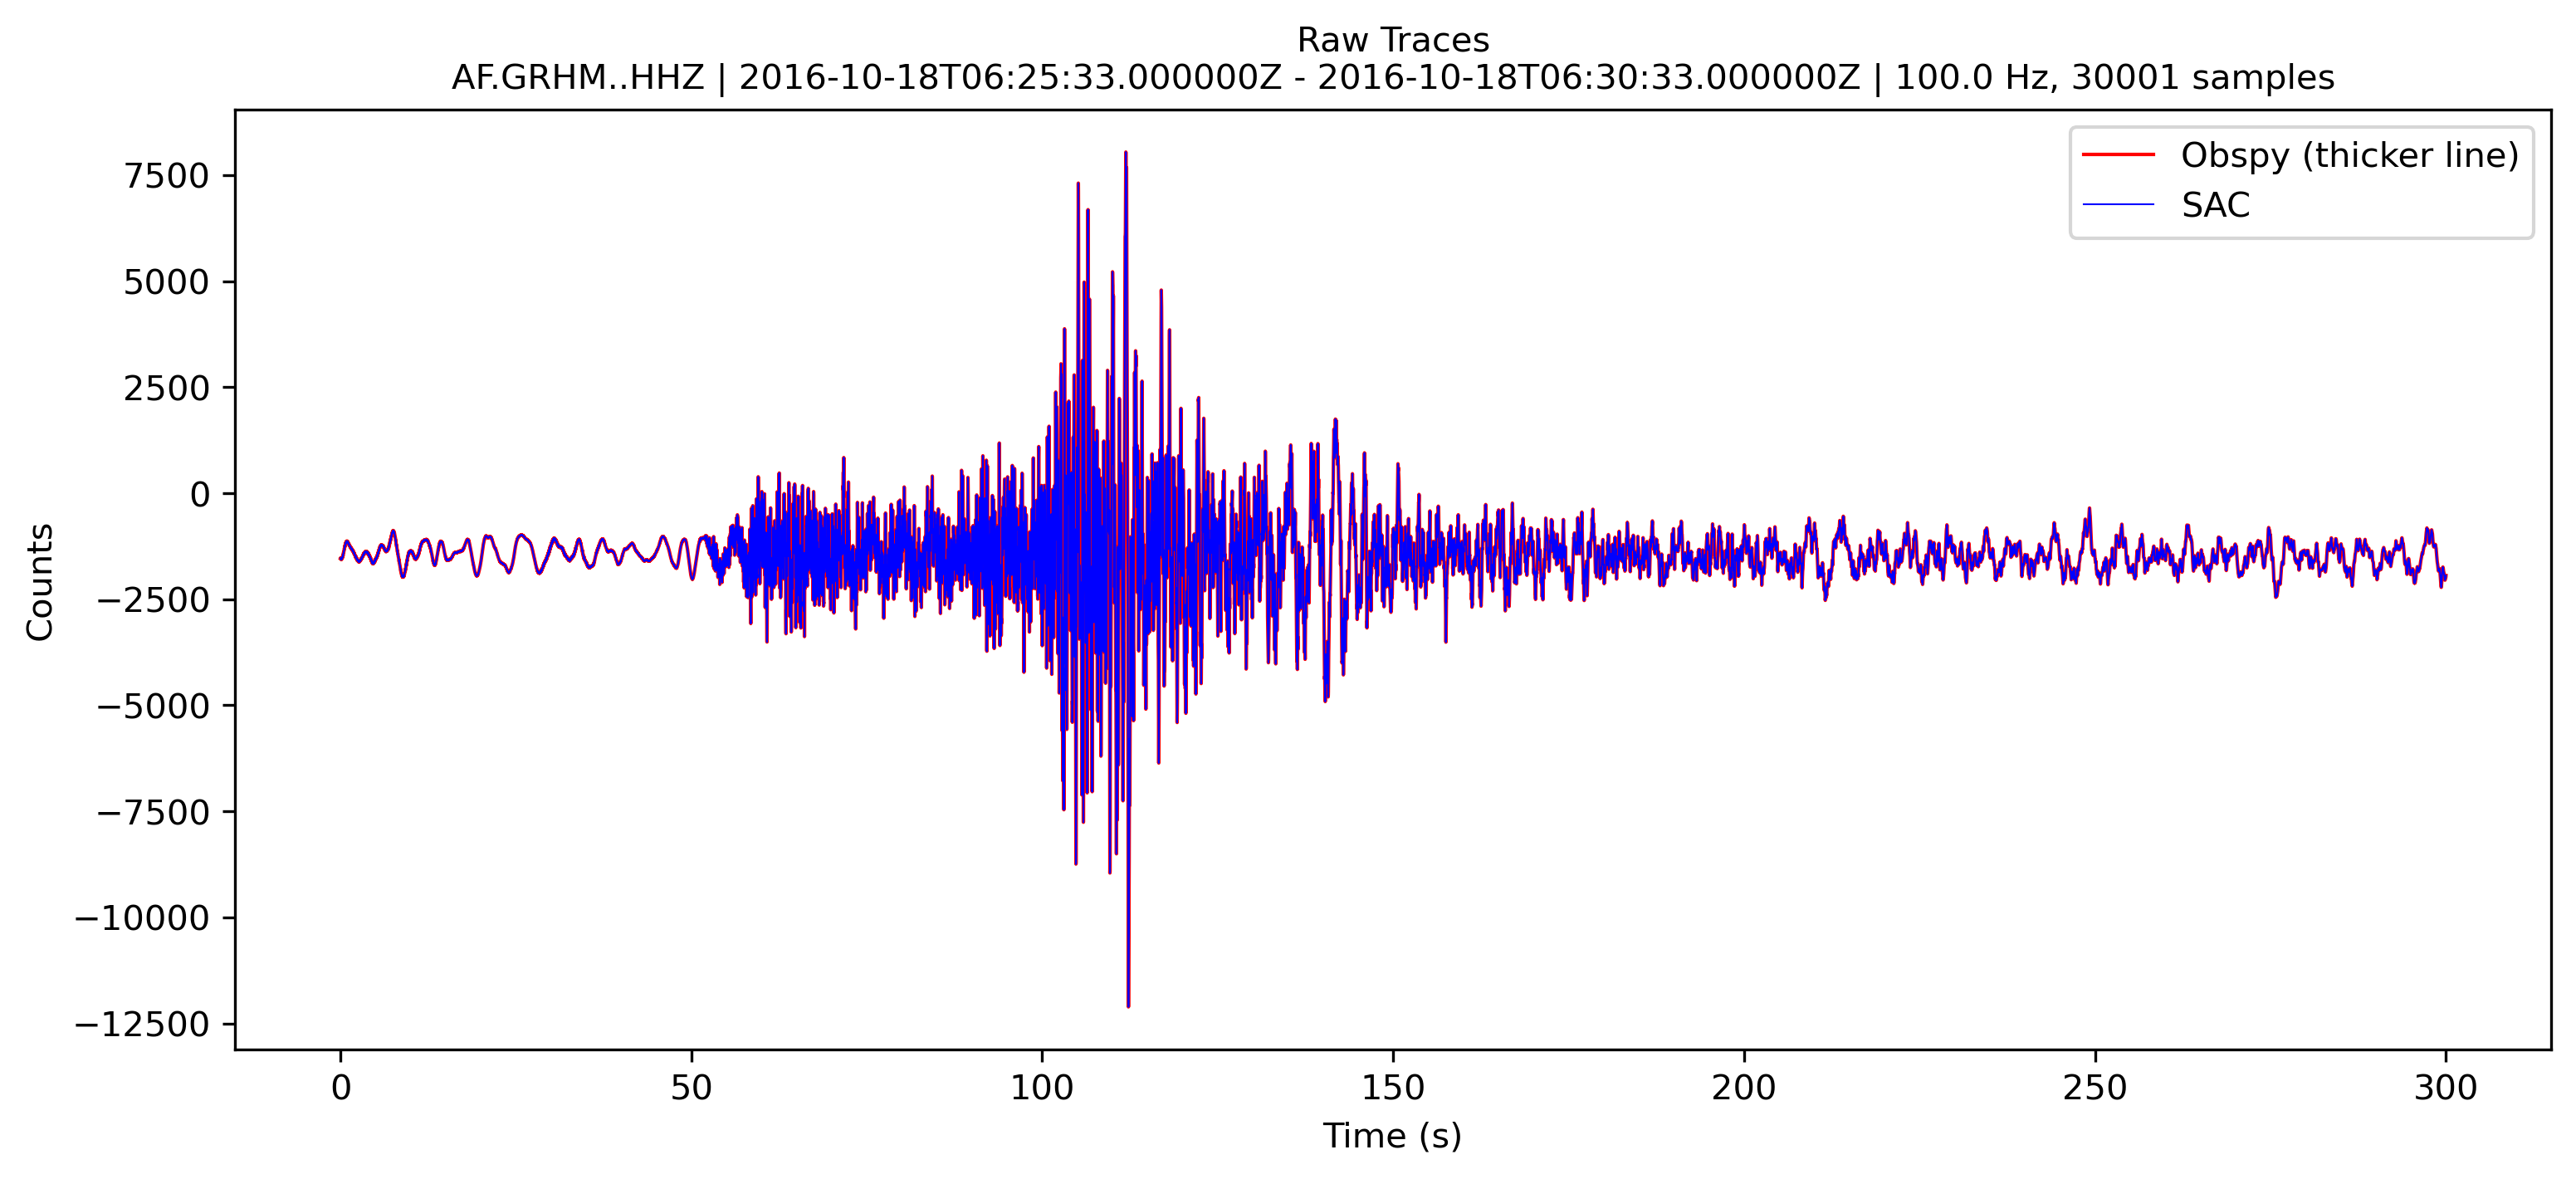

In [9]:
#raw traces

#read in 3 components for M4.5 at GRHM
st = obspy.read('waveforms/*GRHM*') 
#trim 300 - 600 sec from start    
st.trim(st[2].stats.starttime+300, st[2].stats.starttime+600)
#set st to just vertical component
st = st[2]


#katie's raw, cut sac file
'''add corresponding sac commands'''
st_sac = obspy.read(r"sac_traces/GRHM_HHZ_cut_raw.sac")[0]

print(st)
print(st_sac)

plt.figure(figsize=(12,5), dpi=300)
plt.title('Raw Traces\n'+ str(st), fontsize=10)
plt.ylabel('Counts')
plt.xlabel('Time (s)')
plt.plot(st.times(), st.data, linewidth=1, color='r', label='Obspy (thicker line)')
plt.plot(st_sac.times(), st_sac.data, linewidth=0.5, color='b', label='SAC')
plt.legend()
plt.show()
#plt.savefig(os.path.join(data_path, 'obspy_sac_comparison', 'raw_traces'))
#waveforms match

AF.GRHM..HHZ | 2016-10-18T06:25:33.000000Z - 2016-10-18T06:30:33.000000Z | 100.0 Hz, 30001 samples
AF.GRHM..HHZ | 2016-10-18T06:25:33.000000Z - 2016-10-18T06:30:33.000000Z | 100.0 Hz, 30001 samples


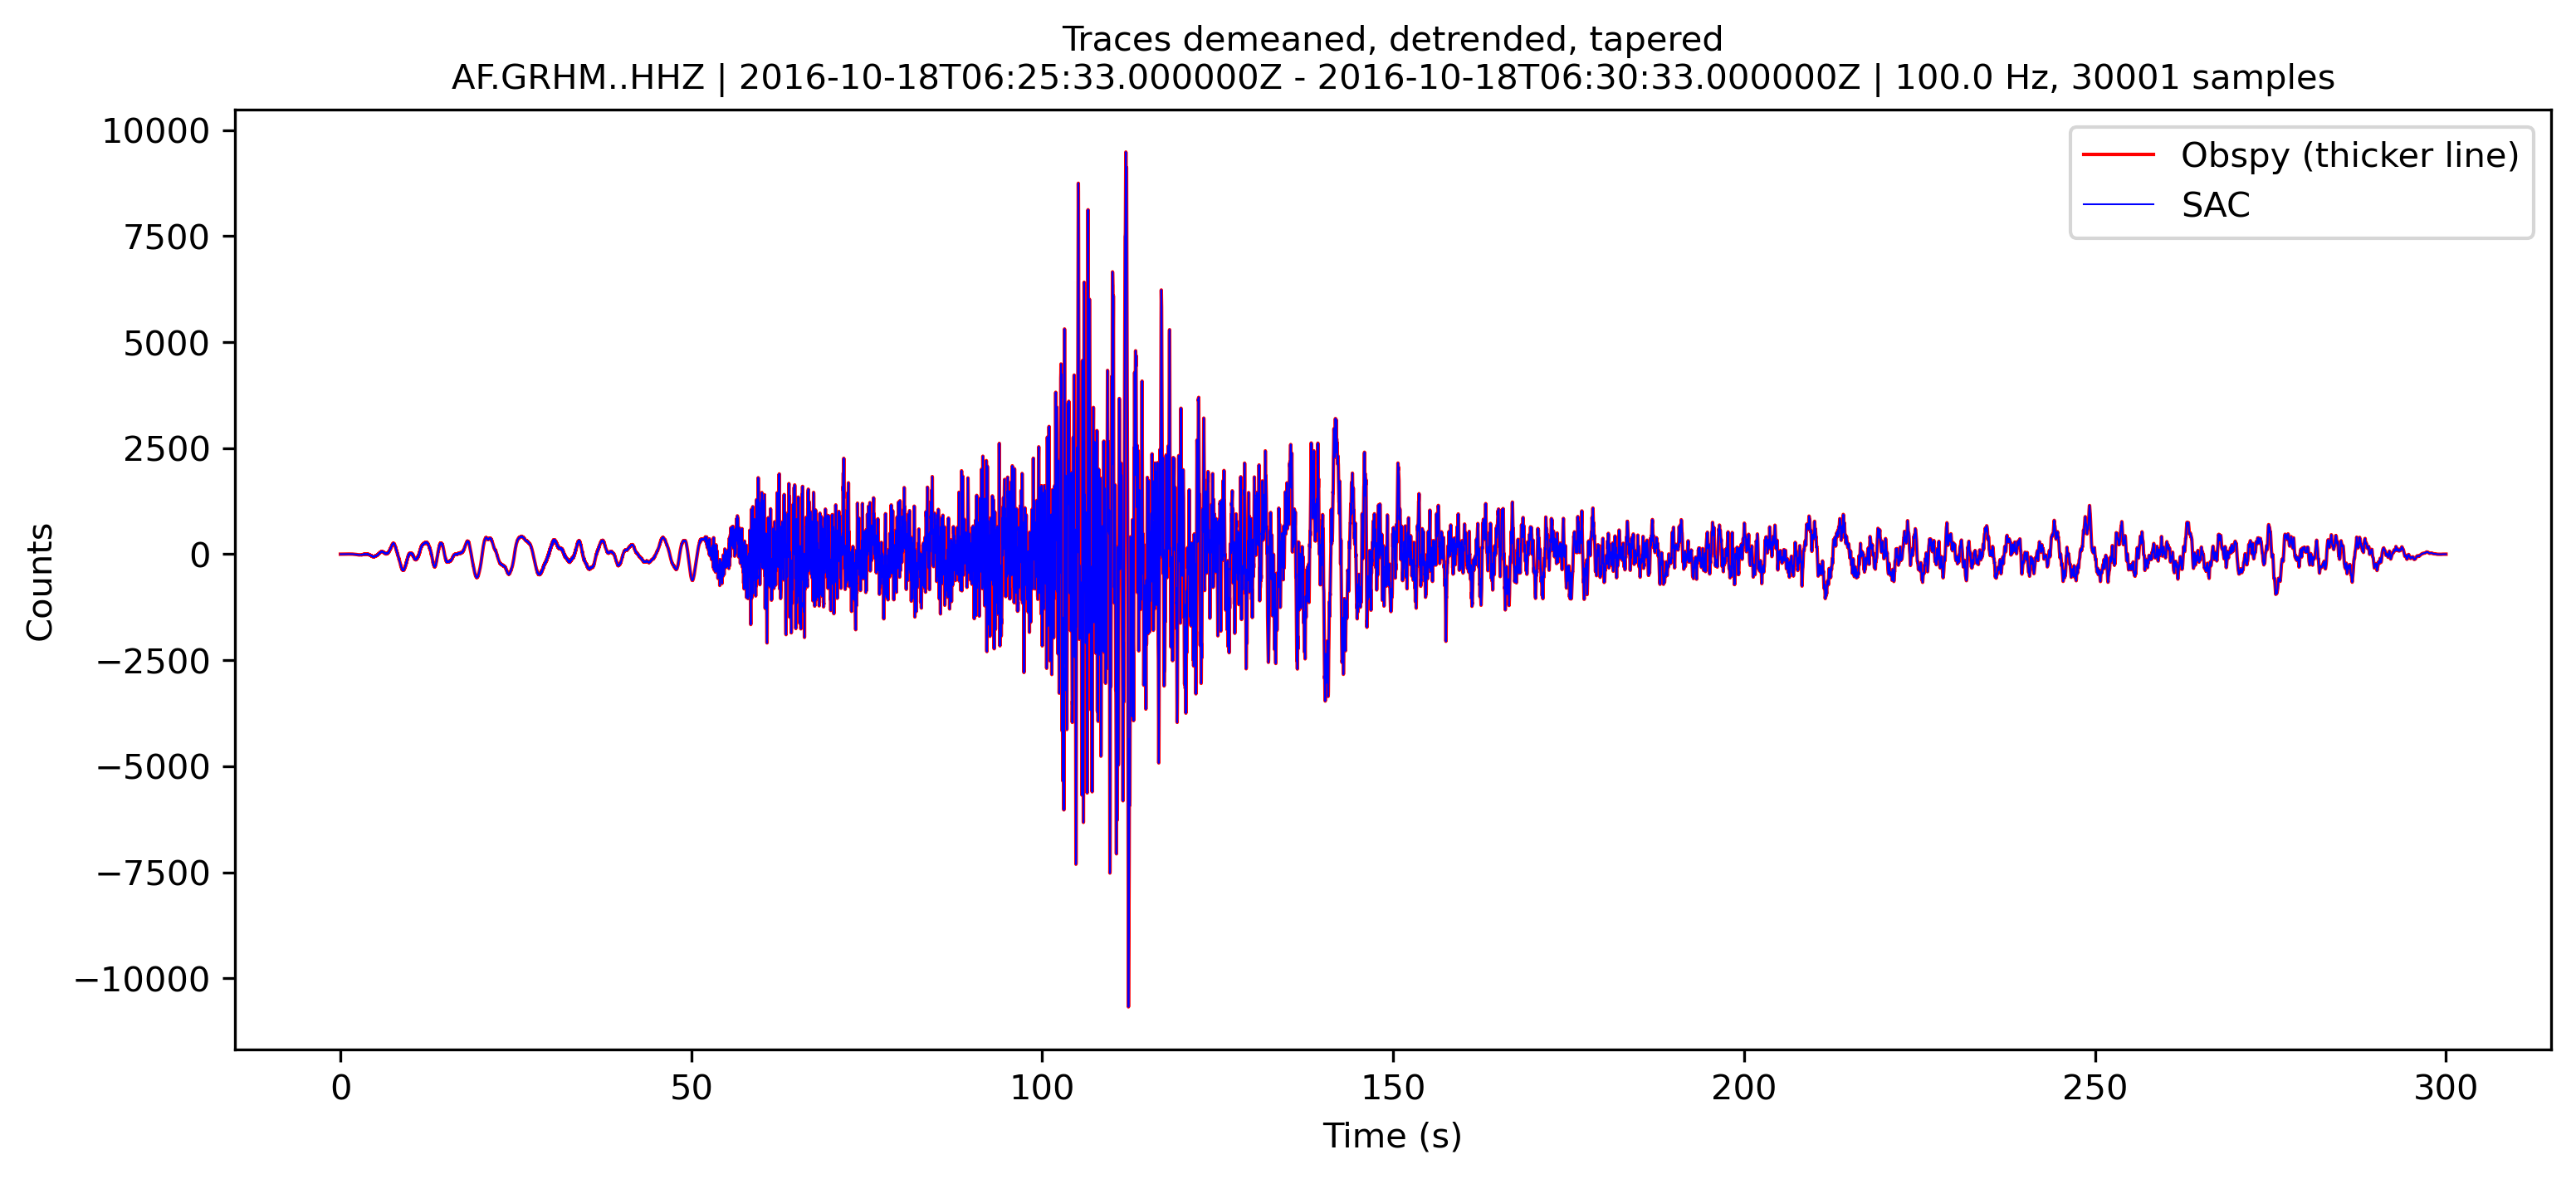

In [12]:
#detrend, demean, taper

st_ddt = st.copy()
#demean - "Mean of data is subtracted"
st_ddt.detrend('demean')
#detrend - "Fitting a linear function to the trace with least squares and subtracting it"
st_ddt.detrend('linear')

#taper - default Hann window, both sides, max_percentage = length of taper at one end in seconds
st_ddt.taper(max_percentage=.05)

#corresponding SAC processing:
sac_ddt = obspy.read("sac_traces/GRHM_HHZ_cut_rmean_rtrend_taper.sac")[0]

print(st_ddt)
print(sac_ddt)

# demean, detrend, taper look the same
plt.figure(figsize=(12,5), dpi=300)
plt.title('Traces demeaned, detrended, tapered\n'+ str(st),fontsize=10)
plt.ylabel('Counts')
plt.xlabel('Time (s)')
plt.plot(st_ddt.times(), st_ddt.data, linewidth=1, color='r', label='Obspy (thicker line)')
plt.plot(sac_ddt.times(), sac_ddt.data, linewidth=0.5, color='b', label='SAC')
plt.legend()
plt.show()
#plt.savefig(os.path.join(data_path, 'obspy_sac_comparison', 'demean_detrend_taper'))

In [ ]:
inv = obspy.read_inventory('stations/*RESP*GR*')) #RESP files


#make copy of ddt waveform
st_r = st_ddt.copy()

#determine nyquist f
nyq = st_r.stats.sampling_rate/2
#set prefilter according to nyquist
prefilter = [0.05, 0.1, nyq/2, nyq]
#find matching response
st_r.remove_response(inventory=inv,
                            pre_filt = prefilter,
                            output = "DISP", 
                            plot=True)

#SAC corresponding waveform, transformed to displacement (m)
sac_rm_disp = obspy.read(r"sac_traces\GRHM_HHZ_disp.sac")[0]




plt.figure(figsize=(12,5), dpi=300)
plt.title('Response Removed\n'+ str(st), fontsize=10)
plt.ylabel('Displacement (m)')
plt.xlabel('Time (s)')


plt.plot(st_r.times(), st_r.data, linewidth=1, color='r', label='Obspy (thicker line)')
plt.plot(sac_rm_disp.times(), sac_rm_disp.data, linewidth=0.5, color='b', label='SAC')
plt.legend()
plt.show()


In [ ]:
st_fft = obspy.read(r'waveforms/*GRHM*')[2]
#cut
st_fft.trim(st_fft.stats.starttime+300, st_fft.stats.starttime+599.28) #29929 npts

#demean - "Mean of data is subtracted"
st_fft.detrend('demean')
#detrend - "Fitting a linear function to the trace with least squares and subtracting it"
st_fft.detrend('linear')
#taper - default Hann window, both sides, max_percentage = length of taper at one end in seconds
st_fft.taper(max_percentage=.05)
nyq = st_fft.stats.sampling_rate/2
#set prefilter according to nyquist
prefilter = [0.05, 0.1, nyq/2, nyq]
#rm reponse
st_fft.remove_response(inventory=inv,
                            pre_filt = prefilter,
                            output = "DISP", 
                            plot=False)
#highpass
st_fft.filter('highpass', freq=0.4, corners=4, zerophase=False)

#SAC corresponding waveform
sac_hp_fft = obspy.read(r"sac_traces\GRHM_noInst_hpforFAS.sac")[0]

print(st_fft)
print(sac_hp_fft)

plt.figure(figsize=(12,5), dpi=300)
plt.title('DDTRR Highpassed for FFT\n'+ str(st), fontsize=10)
plt.ylabel('Displacement (m)')
plt.xlabel('Time (s)')


plt.plot(st_fft.times(), st_fft.data, linewidth=1, color='r', label='Obspy (thicker line)')
plt.plot(sac_hp_fft.times(), sac_hp_fft.data, linewidth=0.5, color='b', label='SAC')
# plt.legend()
plt.show()
#plt.savefig(os.path.join(data_path, 'obspy_sac_comparison', 'ddtrrhp_for_fft'))



In [ ]:
def fas(tr):
    #tr: obspy trace object
    # pad = next_fast_len(len(tr), real=True) #zero pad to next fast len
    next_pow2 = int(2**np.ceil(np.log(len(tr))/np.log(2)))
    # pad = len(ky) #match length of katie's fft, except it's short
    y = fft(tr.data, next_pow2)
    print(len(y))
    yf = 2.0/len(y)*np.abs(y[:(len(y)//2)])
    # yf = 2.0*np.abs(y[:(len(y)//2)])

    # print(np.abs(y[:(len(y)//2)]))
    xf = fftfreq(len(y), tr.stats.delta)[:(len(y)//2)]
    return xf, yf


#get FAS of obspy waveform
tx, ty = fas(st_fft)  


#SAC fft
sac_fft = obspy.read(r"sac_traces\GRHM_fft.sac")[0]
kx, ky = sac_fft.times(), sac_fft.data

#find ratio between FAS - not constant?
ratio = ky[:-1]/ty
# ratio[0] = 1


#plot
fig, ax = plt.subplots()
ax.plot(tx, ty, linewidth=0.5, color='r',  label='Python')
ax.plot(kx,ky, linewidth=0.5, color='b', label = 'SAC')
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Amplitude")
#set yscale to 'log' or 'linear'
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()
#plt.savefig(os.path.join(data_path, 'obspy_sac_comparison', 'FAS'))


